# MicroFit
A small, pure Python library for fitting MicroBooNE data.

## Prerequisites

Follow these instructions to set up the Conda environment: https://github.com/ubneutrinos/searchingfornues/wiki/CONDA-setup-for-python3 . Some additional packages may be needed that can be installed with `conda install` or `pip install` as needed.
You will need a file `localSettings.py` in the root directory of this repository that defines the root directory where all the data lives that at least contains:
```python
ntuple_path = '/path/to/ntuples'
```

Further, you will need to make sure that all the data files you want to load are listed in `data_paths.yml`.

## Loading Data
You can load any number of runs with any selection of truth-filtered data sets using the `load_runs` function defined in `data_loading.py`. With caching enabled, individual dataframes will be stored to disk for faster loading in the future. The first variable returned by the function is a dictionary where the keys are the names of the datasets and the values are the corresponding dataframes. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os 
from data_loading import load_runs

RUN = ["1"]  # this can be a list of several runs, i.e. [1,2,3]
rundata, mc_weights, data_pot = load_runs(
    RUN,
    data="bnb",  # which data to load
    # truth_filtered_sets=["nue", "drt", "nc_pi0", "cc_pi0", "cc_nopi", "cc_cpi", "nc_nopi", "nc_cpi"],
    # Which truth-filtered MC sets to load in addition to the main MC set. At least nu_e and dirt
    # are highly recommended because the statistics at the final level of the selection are very low.
    truth_filtered_sets=["nue", "drt"],
    # Choose which additional variables to load. Which ones are required may depend on the selection
    # you wish to apply.
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    # Load the nu_e set one more time with the LEE weights applied
    load_lee=True,
    # With the cache enabled, by default the loaded dataframes will be stored as HDF5 files
    # in the 'cached_dataframes' folder. This will speed up subsequent loading of the same data.
    enable_cache=True,
    # Since this is Open Data, we are allowed to unblind the data. By default, the data is blinded.
    blinded=False,
)

Loading lee sample


In [3]:
rundata.keys()

dict_keys(['data', 'ext', 'mc', 'nue', 'drt', 'lee'])

In [4]:
rundata["mc"]

,shr_tkfit_2cm_nhits_U,pi0_dedx1_fit_V,shr_tkfit_2cm_dedx_V,endmuonmichel,shr_hits_y_tot,pi0truth_gamma2_dist,shr2_id,shr_dedx_V,elec_e,weightSplineTimesTune,...,dy,dz,dr,paper_category,paper_category_xsec,paper_category_numu,category_1e1p,dataset,weights,weights_no_tune
entry,,,,,,,,,,,,,,,,,,,,,
0,5,1.446966e+00,4.021262e+00,0.041618,41,-1.000000,0,0.784295,0.0,1.000000,...,-0.155454,-0.143097,0.211768,2,2,2,2,mc,0.130186,0.130186
1,1,3.788634e+00,2.124758e+00,0.000637,37,-1.000000,0,1.015840,0.0,1.000000,...,0.090927,0.135254,0.170766,2,2,2,12,mc,0.130186,0.130186
2,0,5.298896e+00,6.328261e+00,0.000911,302,14.172041,0,2.929878,0.0,1.000000,...,-0.155703,-0.838928,0.853762,31,31,2,12,mc,0.130186,0.130186
3,1,5.298896e+00,3.204854e+00,0.000826,359,8.808715,0,0.310502,0.0,1.000000,...,0.597797,0.057831,0.681040,31,31,2,21,mc,0.130186,0.130186
4,0,5.298896e+00,-3.402823e+38,0.001137,120,-1.000000,4,0.031563,0.0,1.000000,...,1.125980,-1.834167,2.179828,2,2,2,13,mc,0.130186,0.130186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31449,3,1.074716e+00,6.750297e+00,0.000000,140,6.584944,0,4.734364,0.0,1.000000,...,-0.203354,0.005127,0.217784,31,31,2,12,mc,0.130186,0.130186
31450,7,2.452548e+00,2.594688e+00,0.033032,55,-1.000000,0,3.468341,0.0,1.237079,...,254.107513,172.795624,308.342957,2,2,2,12,mc,0.161050,0.129699
31451,5,3.842993e+00,4.599150e+00,0.000000,73,67.616211,0,4.922271,0.0,1.000000,...,6.810709,1.183167,9.248138,31,31,2,13,mc,0.130186,0.130186


The dataframes have already been concatenated over the runs and are weighted such that the total norm should match that of the data. The weights are stored in the `weights` column. We can use it to make a simple histogram even without the rest of the framework. Also, events for which truth-filtered sets have been loaded are already removed from the "mc" set, so there is no need to worry about double-counting of events. When we plot the stacked histogram of all MC and EXT on top of the data, we should see a good agreement.

['drt', 'mc', 'nue', 'ext']


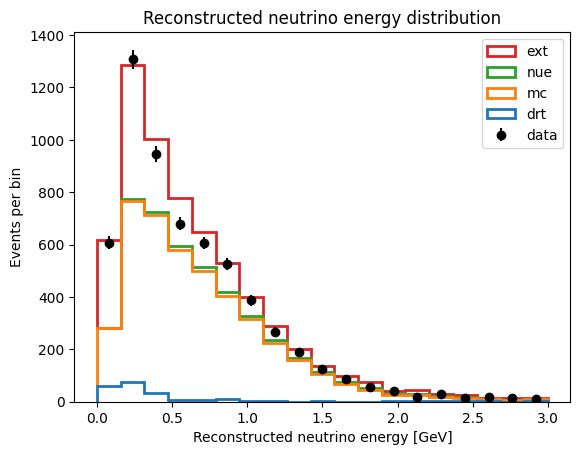

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution of reconstructed neutrino energy (`reco_e`).
# We have to set the binning manually because sometimes a filler value is used
# that is a very large number. To get the total predicted number of events,
# we have to add all MC sets and the EXT data set.

bins = np.linspace(0, 3, 20)
background_keys = list(set(rundata.keys()) - set(["data", "lee"]))
print(background_keys)
plt.hist(
    [rundata[key]["reco_e"] for key in background_keys],
    bins=bins,
    weights=[rundata[key]["weights"] for key in background_keys],
    histtype="step",
    lw=2,
    stacked=True,
    label=[key for key in background_keys],
)
# show data hist on top as points with error bars
data_bin_content, data_bin_edges = np.histogram(
    rundata["data"]["reco_e"], bins=bins, weights=rundata["data"]["weights"]
)
data_bin_errors = np.sqrt(data_bin_content)
data_bin_centers = (data_bin_edges[:-1] + data_bin_edges[1:]) / 2
plt.errorbar(
    data_bin_centers,
    data_bin_content,
    yerr=data_bin_errors,
    fmt="o",
    label="data",
    color="black",
)
plt.legend()
plt.xlabel("Reconstructed neutrino energy [GeV]")
plt.ylabel("Events per bin")
plt.title("Reconstructed neutrino energy distribution")
plt.show()

## The RunHistGenerator

The `RunHistGenerator` class is defined in `histogram.py` and is mainly responsible for making histograms of full runs with annotated event categories. Most importantly, this class also handles the calculation of the systematic uncertainties as a covariance matrix using "multisim" and "unisim" weights.

In [6]:
from microfit.histogram import Binning, Histogram, RunHistGenerator

# The query strings for the selection are defined in the `selections.py` file.
selection = "NPBDT"
preselection = "NP"
# Binnings are defined by the variable to be binned, the number of bins, and the range, and the label.
binning_def = ("reco_e", 10, (0.15, 1.55), r"Reconstructed Energy [GeV]")
binning = Binning.from_config(*binning_def)
# The binning is a class with a defined repr:
binning

Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False, selection_query=None)

In [7]:
signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
)

The objects returned by the `RunHistGenerator` are of type `Histogram`. This class not only stored bin counts, but also the associated covariance matrices and simplifies arithmatic with histograms. For example, we can add or multiply two histograms together and the covariance will be appropriately propagated automatically. The `Histogram` class also has a `plot` method that can be used to plot the histogram with error bands.

Histogram(binning=Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False, selection_query=None), bin_counts=[0.6480687652616443+/-1.0414316638858991
 2.308074229773891+/-0.46002897312225816
 2.8567978438662167+/-0.49878876474284944
 3.0180154554032637+/-0.5188425609048453
 2.1492758021520793+/-0.3411374260232986
 2.8127763969767106+/-0.5229679970130083
 1.8041196446169803+/-0.3997586314353934
 1.3303665687910868+/-0.24674726214916598
 1.1532703915036642+/-0.20410994112866138
 0.9708984939596732+/-0.17633716315140352], label=MC+EXT, tex=MC+EXT)

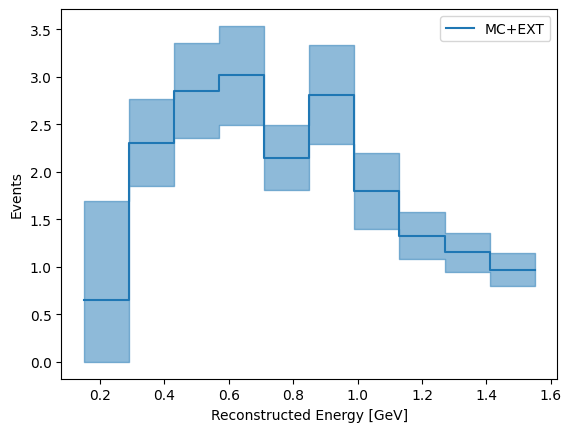

In [8]:
total_prediction = signal_generator.get_total_prediction(include_multisim_errors=True)
# The `Histogram` class also defines a repr that makes a nice plot when run inside a Jupyter notebook:
total_prediction

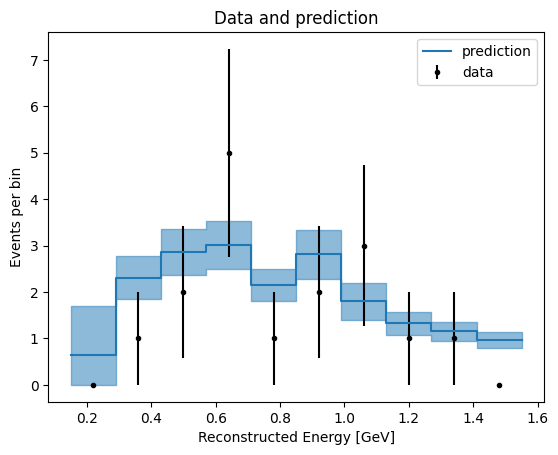

In [9]:
data_hist = signal_generator.get_data_hist()
fig, ax = plt.subplots()
data_hist.draw(ax=ax, label="data", as_errorbars=True)
total_prediction.draw(ax=ax, label="prediction", as_errorbars=False)
ax.legend()
ax.set_xlabel(binning.label)
ax.set_ylabel("Events per bin")
ax.set_title("Data and prediction")
plt.show()

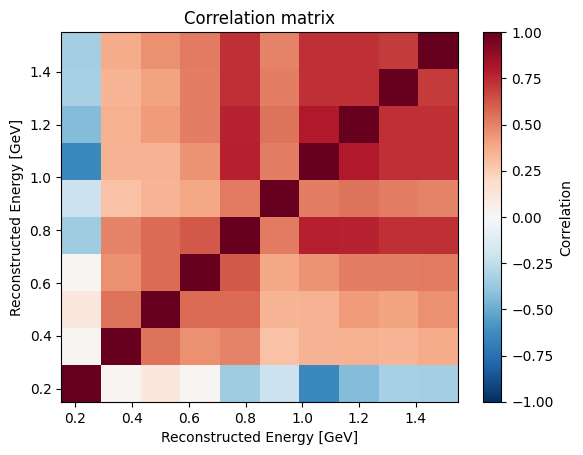

In [10]:
# We can also ask it to draw the covariance matrix
fig, ax = plt.subplots()
total_prediction.draw_covariance_matrix(ax=ax)
plt.show()

Histograms can also be divided to calculate the ratio. The covariance will be correctly propagated. 

/nashome/a/atrettin/PELEE/microfit/statistics.py:407: RuntimeWarning: divide by zero encountered in double_scalars
  Cy[i, i] = y[i] ** 2 * (C1[i, i] / x1[i] ** 2 + C2[i, i] / x2[i] ** 2)
/nashome/a/atrettin/PELEE/microfit/statistics.py:407: RuntimeWarning: invalid value encountered in double_scalars
  Cy[i, i] = y[i] ** 2 * (C1[i, i] / x1[i] ** 2 + C2[i, i] / x2[i] ** 2)
/nashome/a/atrettin/PELEE/microfit/statistics.py:410: RuntimeWarning: invalid value encountered in double_scalars
  Cy[i, j] = y[i] * y[j] * (C1[i, j] / (x1[i] * x1[j]) + C2[i, j] / (x2[i] * x2[j]))


<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

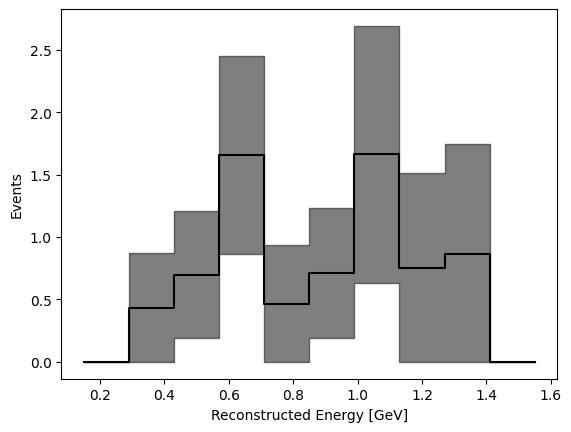

In [11]:
data_mc_ratio = data_hist / total_prediction
fig, ax = plt.subplots()
data_mc_ratio.draw(ax=ax, label="data / prediction", as_errorbars=False)

## The RunHistPlotter

A more convent way to plot the histograms generated by the `RunHistGenerator` is to use the `RunHistPlotter` class defined in `run_plotter.py`.

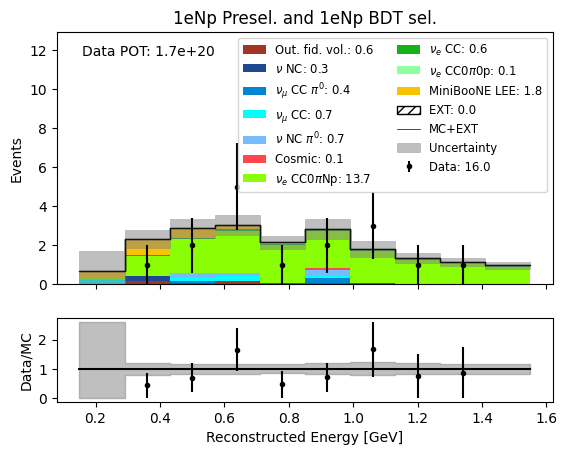

In [12]:
from microfit.run_plotter import RunHistPlotter

plotter = RunHistPlotter(signal_generator)
# The category column can be used to split the prediction into different categories.
# Predefined categories are "category", "paper_category", "paper_category_xsec" and "category_1e1p".
# New categories can be added by adding a corresponding column to the dataframe and then define
# the labels in the file `category_definitions.py`.
ax = plotter.plot(
    category_column="category",
    include_multisim_errors=True,
    add_ext_error_floor=False,
    show_data_mc_ratio=True,
)

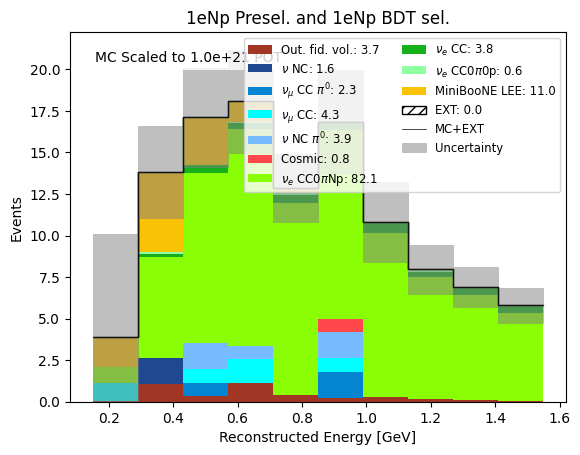

In [13]:
# We can also choose to rescale the data to any given POT.
# In that case, no data is shown.
ax = plotter.plot(
    category_column="category",
    include_multisim_errors=True,
    add_ext_error_floor=False,
    scale_to_pot=1e21,
)

## Adding a sideband constraint

The framework supports the use of _one_ sideband measurement that can be used to constrain several signal bands simultaneously. To do so, simply add the `RunHistGenerator` for the sideband as an argument to the `RunHistGenerator` of the signal.

In [14]:
# First, we need to load the sideband data. We use the numu sideband.
RUN = ["3"]

rundata_numu, mc_weights_numu, data_pot_numu = load_runs(
    RUN,
    data="opendata_bnb",
    truth_filtered_sets=["nue", "drt"],
    loadshowervariables=False,
    loadsystematics=True,
    use_bdt=False,
    # set this to true to let the data loading function know that we are loading numu
    numupresel=True,
    loadnumuvariables=True,
    load_crt_vars=True,
    blinded=False,  # sideband needs to be unblinded to work
    enable_cache=True,
)

In [15]:
# note that the sideband is binned by a different variable
sideband_binning = Binning.from_config("neutrino_energy", 14, (0.15, 1.55), "neutrino reconstructed energy [GeV]")

sideband_generator = RunHistGenerator(
    rundata_numu,
    sideband_binning,
    data_pot=data_pot_numu,
    selection="NUMU",
    preselection="NUMU",
)
sideband_plotter = RunHistPlotter(sideband_generator)

<AxesSubplot:title={'center':'$\\nu_{\\mu}$ selection and $\\nu_{\\mu}$ selection'}, xlabel='neutrino reconstructed energy [GeV]', ylabel='Events'>

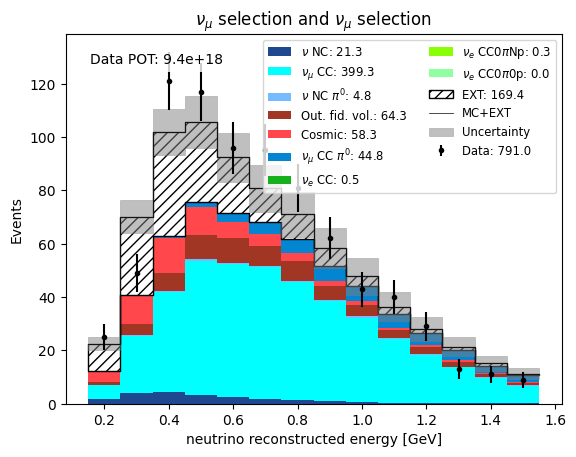

In [16]:
sideband_plotter.plot(include_multisim_errors=True, add_ext_error_floor=False, category_column="category")

We can see from the histogram that the data flux is a bit higher than the prediction. We will see that the correction due to the presence of the sideband will also increase the predicted bin count in the signal region. The total histogram, shown as the black line, no longer coincides with the stacked histogram because only it includes the sideband correction.

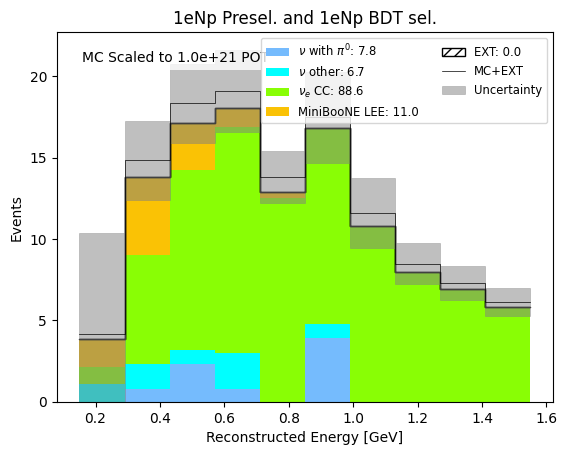

In [17]:
signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=sideband_generator,
)
signal_plotter = RunHistPlotter(signal_generator)
ax = signal_plotter.plot(
    include_multisim_errors=True,
    add_ext_error_floor=False,
    use_sideband=True,
    category_column="paper_category",
    scale_to_pot=1e21,
)

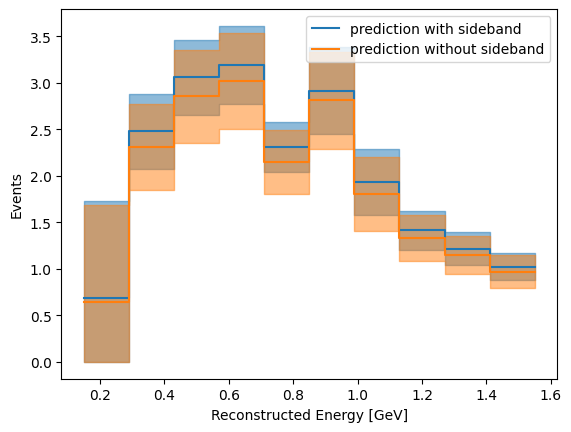

In [18]:
# show the total prediction with and without the sideband in the same plot.
# The predicted values are a bit higher but the size of the errors is also reduced.
total_prediction_with_sideband = signal_generator.get_total_prediction(
    include_multisim_errors=True, use_sideband=True
)
fig, ax = plt.subplots()
total_prediction_with_sideband.draw(
    ax=ax, label="prediction with sideband", as_errorbars=False
)
total_prediction.draw(ax=ax, label="prediction without sideband", as_errorbars=False)
ax.legend()

### 

### Introducing parameters

To eventually run an analysis, we have to be able to generate histograms under differen hypotheses. This is done by replacing the object that calculates the histograms with one that can be configured with parameters. When the `RunHistGenerator` is initialized, we can pass a sub-class of the default `HistogramGenerator` (also defined in `histogram.py`).

For the case of the LEE analysis, we can use a pre-defined class called `SignalOverBackgroundGenerator`, which accepts a `signal_strength` parameter.

In [19]:
from microfit.signal_generators import SignalOverBackgroundGenerator
from microfit.parameters import Parameter, ParameterSet

signal_parameters = ParameterSet(
    [
        Parameter("signal_strength", 1.0, bounds=(0, 10)),
    ]
)

signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    # sideband_generator=sideband_generator,  # the sideband generator can be used here as well
    # This overrides the default `HistogramGenerator` class, which just produces 
    # a histogram without any parametrization.
    mc_hist_generator_cls=SignalOverBackgroundGenerator,
    parameters=signal_parameters,
)
signal_plotter = RunHistPlotter(signal_generator)

<AxesSubplot:title={'center':'1eNp Presel. and 1eNp BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

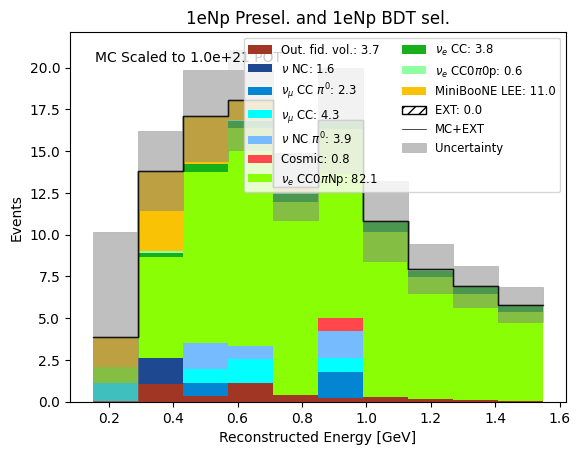

In [20]:
# The ParameterSet defines a set of parameters that may be used by several signal generators at once. 
signal_plotter.plot(include_multisim_errors=True, add_ext_error_floor=False, category_column="category", scale_to_pot=1e21)

#### Manipulatin parameters

When manipulating parameters, be sure to alway set the _value_ and not replace the actual parameter object! This is necessary because parameters may be shared _by reference_ between different `RunHistGenerator` objects to synchronize parameters between signals.

In [21]:
signal_generator.parameters["signal_strength"].value = 5.0

<AxesSubplot:title={'center':'1eNp Presel. and 1eNp BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

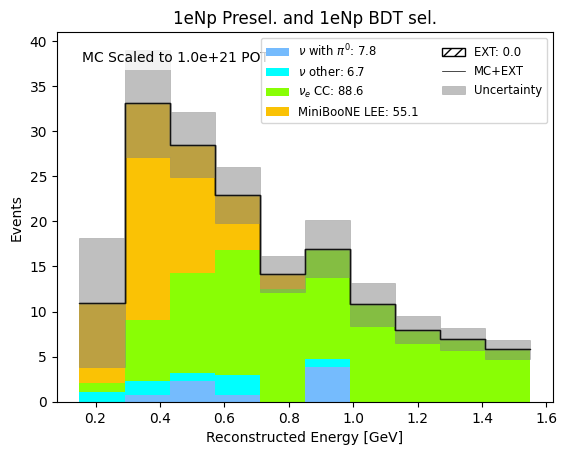

In [22]:
# The change in signal strength is reflected in the plot.
signal_plotter.plot(include_multisim_errors=True, add_ext_error_floor=False, category_column="paper_category", scale_to_pot=1e21)

### Parameter sharing

Parameters can be shared by reference between different signal generators.

In [23]:
second_signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection="ZPBDT",
    preselection="ZP",
    mc_hist_generator_cls=SignalOverBackgroundGenerator,
    parameters=signal_parameters,
)
second_signal_plotter = RunHistPlotter(second_signal_generator)

<AxesSubplot:title={'center':'1e0p Presel. and 1e0p BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

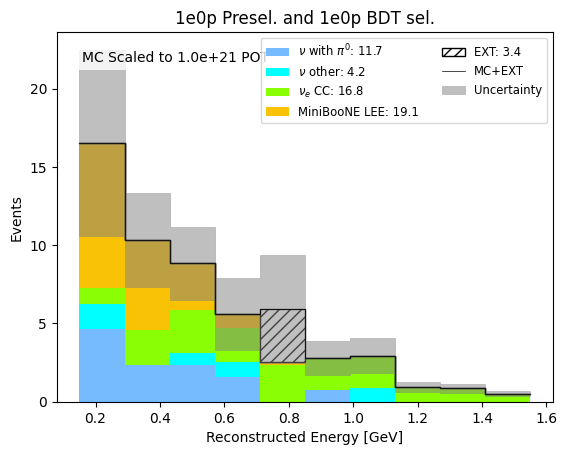

In [24]:
second_signal_plotter.plot(include_multisim_errors=True, add_ext_error_floor=False, category_column="paper_category", scale_to_pot=1e21)

In [25]:
# we can show that the actual parameter objects are the same
print(signal_generator.parameters is second_signal_generator.parameters)

True


<AxesSubplot:title={'center':'1e0p Presel. and 1e0p BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

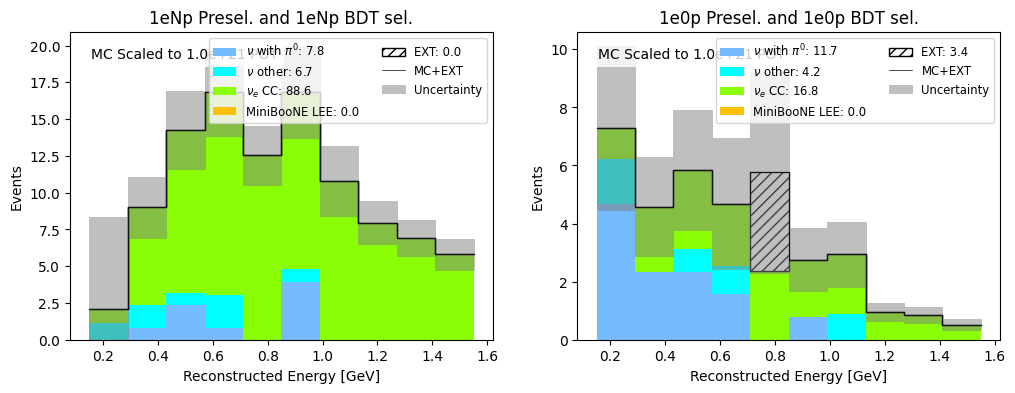

In [26]:
# When we set the parameter to zero in one, the signal disappears in both.
signal_generator.parameters["signal_strength"].value = 0.0
# make two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
signal_plotter.plot(
    ax=ax1,
    include_multisim_errors=True,
    add_ext_error_floor=False,
    category_column="paper_category",
    scale_to_pot=1e21,
)
second_signal_plotter.plot(
    ax=ax2,
    include_multisim_errors=True,
    add_ext_error_floor=False,
    category_column="paper_category",
    scale_to_pot=1e21,
)

## Defining an Analysis

The `MultiBandAnalysis` class defined in `analysis.py` is a convenience class that defines an analysis with multiple signal bands and one optional sideband. It can calculate the full multiband covariance matrix with the sideband constraint and can calculate the chi-square between the data and the prediction.

The class is meant to be used with a TOML file that defines how data is loaded, which selection and which binning to use in every sideband and what parameters to fit. Here, we will initialize it from a TOML string that we turn into a dictionary.

In [27]:
import toml
from microfit.analysis import MultibandAnalysis

toml_string = """
# Define the two hypotheses.
# Note that double brackets define lists in TOML. If there were more than one parameter,
# we would repeat the [[h0_params]] and [[h1_params]] sections.
[[h0_params]]
name = "signal_strength"
value = 0.0

[[h1_params]]
name = "signal_strength"
value = 1.0

# Define how data should be loaded for the sideband.
# These arguments are passed forward to the data loading function.
[sideband_data]
run_numbers = ["3"]
data = "opendata_bnb"
blinded = false
truth_filtered_sets = ["nue", "drt"]
loadshowervariables = false
loadsystematics = true
use_bdt = false
loadpi0variables = false
numupresel = true
load_crt_vars = true
loadnumuvariables = true
enable_cache = true

# Define the sideband selection.
[sideband]
selection = "NUMU"
preselection = "NUMU"

# Define the binning for the sideband.
[sideband.binning]
variable = "neutrino_energy"
n_bins = 14
limits = [0.15, 1.55]
label = "Neutrino reconstructed energy [GeV]"

# Define the default error calculation behavior for the sideband generators.
[sideband.uncertainties]
include_multisim_errors = true
add_ext_error_floor = false
use_sideband = false

# Define how data should be loaded. All signals use the same data but may apply different selections.
[signal_data]
run_numbers = ["3"]
data = "bnb"
blinded = true
# truth_filtered_sets = ["nue", "drt", "cc_pi0", "nc_pi0", "cc_nopi", "cc_cpi", "nc_nopi", "nc_cpi"]
truth_filtered_sets = ["nue", "drt"]
loadshowervariables = true
loadsystematics = true
loadpi0variables = true
loadrecoveryvars = true
load_lee = true
enable_cache=true

# Here we can define any number of signals that we want!
# We just have to repeat the [[signal]] section for each signal.
[[signal]]

    selection = "NPBDT"
    preselection = "NP"
    mc_hist_generator_cls = "SignalOverBackgroundGenerator"

    [signal.uncertainties]
    include_multisim_errors = true
    add_ext_error_floor = false
    use_sideband = true

    [signal.binning]
    variable = "reco_e"
    # n_bins = 17
    # limits = [0.01, 2.39]
    # Reproduce technote
    n_bins = 10
    limits = [0.15, 1.55]
    label = "Reconstructed Energy [ GeV ]"

    # Define the parameters for this signal. Again, this is a list, but we only have one parameter.
    [[signal.parameter]]
    name = "signal_strength"
    value = 1.0
    bounds = [0.0, 10.0]

[[signal]]

    selection = "ZPBDT"
    preselection = "ZP"
    mc_hist_generator_cls = "SignalOverBackgroundGenerator"

    [signal.uncertainties]
    include_multisim_errors = true
    add_ext_error_floor = false
    use_sideband = true

    [signal.binning]
    variable = "reco_e"
    n_bins = 10
    limits = [0.15, 1.55]
    label = "Reconstructed Energy [ GeV ]"

    [[signal.parameter]]
    name = "signal_strength"
    value = 1.0
    bounds = [0.0, 10.0]
"""

analysis = MultibandAnalysis(toml.loads(toml_string))

Making generator for selection NUMU and preselection NUMU
Loading lee sample
Making generator for selection NPBDT and preselection NP
Making generator for selection ZPBDT and preselection ZP


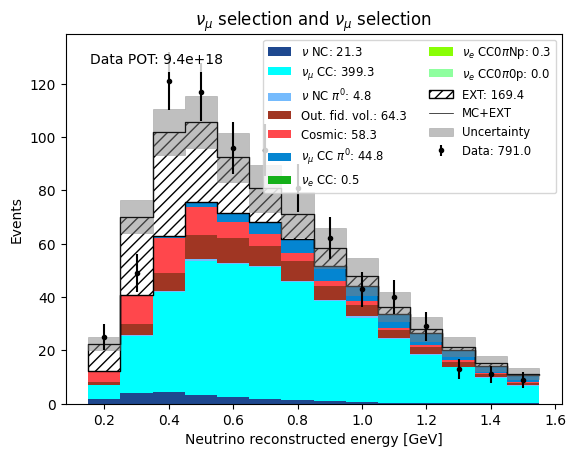

In [28]:
analysis.plot_sideband()

In [29]:
analysis.parameters

Parameters:
Name	Value	Unit	Bounds
-------------------------------
signal_strength	1		(0, 10)

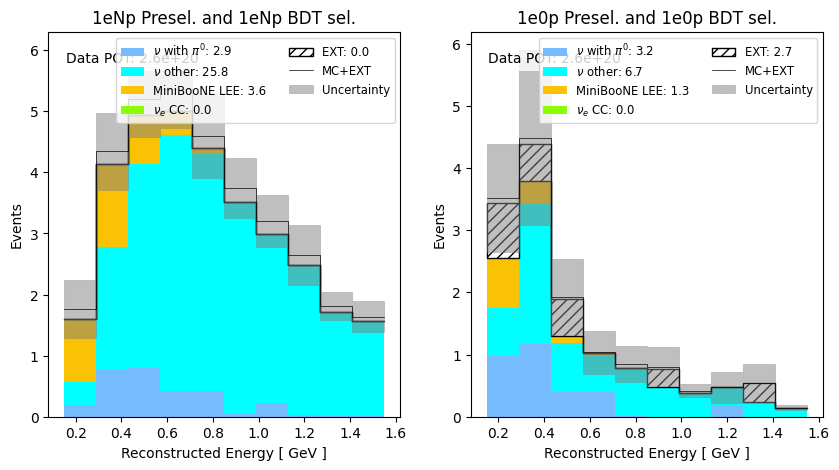

In [30]:
analysis.plot_signals()

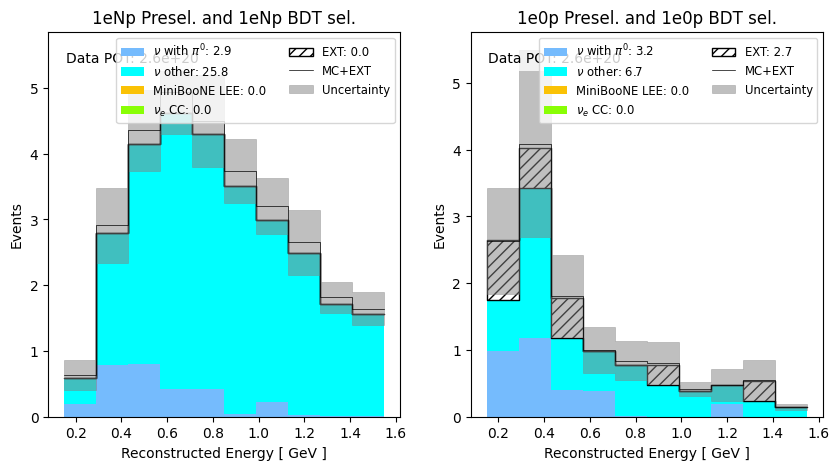

In [31]:
analysis.parameters["signal_strength"].value = 0.0
analysis.plot_signals()

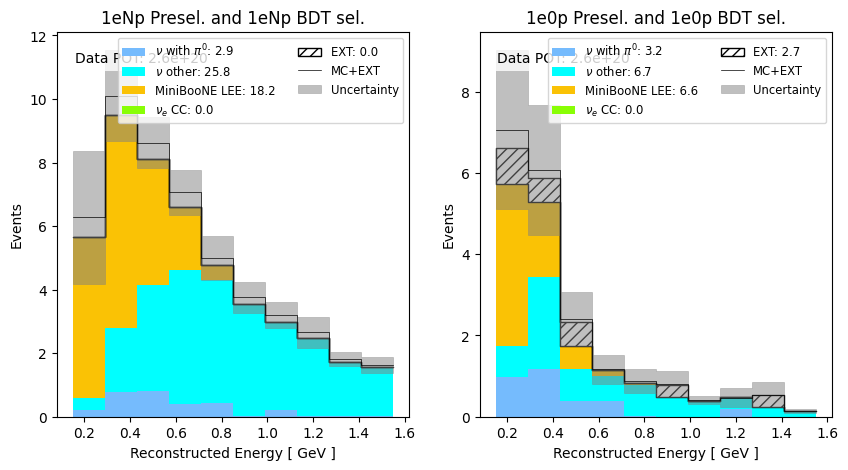

In [32]:
analysis.parameters["signal_strength"].value = 5.0
analysis.plot_signals()

### Run the two-hypothesis test

The analysis defines a function that runs a two-hypothesis test. It will calculate the chi-square for the null hypothesis and the alternative hypothesis for a set number of trials.

In [33]:
two_hypo_result = analysis.two_hypothesis_test(
    h0_params=ParameterSet([Parameter("signal_strength", 0.0)]),
    h1_params=ParameterSet([Parameter("signal_strength", 1.0)]),
    sensitivity_only=True,
    scale_to_pot=1e21,
)

In [34]:
two_hypo_result.keys()

dict_keys(['ts_median_h1', 'median_pval', 'samples_h0', 'samples_h1', 'chi2_h0', 'pval_h0', 'chi2_h1', 'pval_h1'])

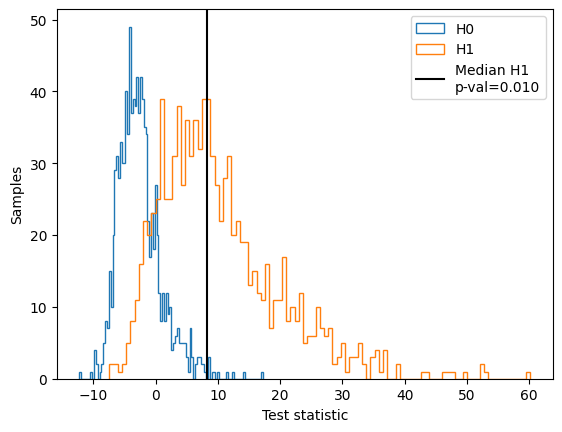

In [35]:
plt.hist(two_hypo_result["samples_h0"], bins=100, label="H0", histtype="step")
plt.hist(two_hypo_result["samples_h1"], bins=100, label="H1", histtype="step")
plt.axvline(two_hypo_result["ts_median_h1"], color="black", label=f"Median H1\np-val={two_hypo_result['median_pval']:.3f}")
plt.legend()
plt.xlabel("Test statistic")
plt.ylabel("Samples")
plt.show()